### Source
Example from @bwengals
https://discourse.pymc.io/t/coregionalization-model-for-two-separable-multidimensional-gaussian-process/2550/4

### NOTES:

- Using find_MAP: seems not correct
- Using trace seems alright

TODOS:
    
- Try to using LatentKron, or Kronecker

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

### generate and then plot the data

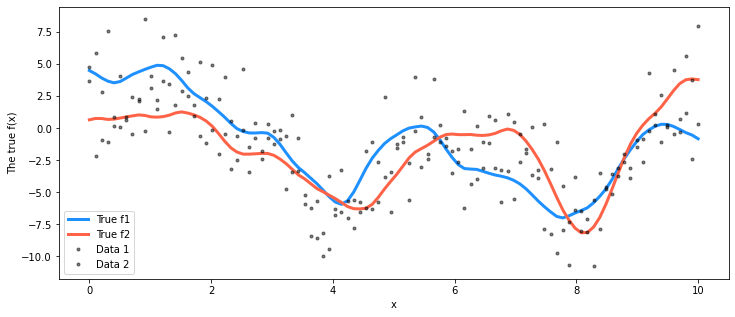

In [2]:
n = 100 
x = np.linspace(0, 10, n)[:, None] 

# true covariance function and its true parameters
ell_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ell_true)
mean_func = pm.gp.mean.Zero()

# two samples from the same gaussian process
f_true1 = np.random.multivariate_normal(mean_func(x).eval(),
                                        cov_func(x).eval() + 1e-8*np.eye(n), 1).flatten()
f_true2 = np.random.multivariate_normal(mean_func(x).eval(),
                                        cov_func(x).eval() + 1e-8*np.eye(n), 1).flatten()


sigma_true = 2.0
f1 = 0.5*f_true1 - 1.0*f_true2
f2 = 1.0*f_true1 + 0.2*f_true2
y1 = f1 + sigma_true * np.random.randn(n)
y2 = f2 + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(x, f1, "dodgerblue", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_xlabel("x"); ax.set_ylabel("The true f(x)"); plt.legend();

### Format the data for the coregionalized GP

In [3]:
x.shape, y1.shape, y2.shape

((100, 1), (100,), (100,))

In [4]:
xx = np.concatenate((x, x), axis=0)
idx = np.concatenate((np.zeros(n), np.ones(n)))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((y1, y2))
X.shape, y.shape

((200, 2), (200,))

### pymc model

In [5]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_890817/46575181.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


### MAP estimate and generate some predictions

In [6]:
with model:
    mp = pm.find_MAP()

In [7]:
mp

{'ell_log__': array(1.38629436),
 'eta_log__': array(1.38629436),
 'W': array([[-1.30653407,  0.07638048],
        [ 0.36723181,  1.23289919]]),
 'kappa_log__': array([0.40546511, 0.40546511]),
 'sigma_log__': array(1.09861229),
 'ell': array(4.),
 'eta': array(4.),
 'kappa': array([1.5, 1.5]),
 'sigma': array(3.)}

In [8]:
x_new = np.linspace(0, 20, 200)[:, None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

In [9]:
x_new.shape, xx_new.shape, idx2.shape, X_new.shape

((200, 1), (400, 1), (400, 1), (400, 2))

In [10]:
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'])

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


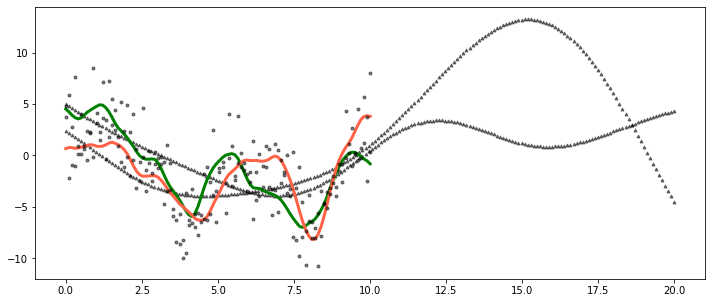

In [11]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = pred_samples.posterior_predictive["f_pred"].squeeze().values
# plot_gp_dist(ax, f_pred[:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
# plot_gp_dist(ax, f_pred[200:], X_new[200:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(X_new[:200,0], f_pred[:200], '^k', ms=3, alpha=0.5, label="Data 1");
ax.plot( X_new[200:,0], f_pred[200:], '^k', ms=3, alpha=0.5, label="Data 2");

ax.plot(x, f1, "green", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");

### Using trace

In [12]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_890817/46575181.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


In [13]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 162 seconds.


CPU times: user 7min 51s, sys: 13min 15s, total: 21min 7s
Wall time: 2min 45s


In [14]:
ell_true, eta_true, sigma_true

(1.0, 3.0, 2.0)

In [15]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",0.139,2.448,-4.314,4.207,0.239,0.169,112.0,219.0,NaN
"W[0, 1]",-0.449,2.219,-4.118,3.500,0.199,0.141,129.0,289.0,NaN
"W[1, 0]",0.274,2.763,-4.679,4.908,0.258,0.183,118.0,112.0,NaN
"W[1, 1]",-0.429,2.600,-4.872,3.995,0.245,0.174,114.0,263.0,NaN
ell,0.773,0.114,0.581,1.006,0.009,0.007,154.0,143.0,NaN
eta,1.293,0.567,0.396,2.400,0.067,0.051,91.0,69.0,NaN
kappa[0],1.342,1.128,0.055,3.391,0.076,0.053,137.0,94.0,NaN
kappa[1],1.430,1.121,0.050,3.409,0.072,0.051,194.0,248.0,NaN
sigma,2.100,0.117,1.910,2.349,0.008,0.006,197.0,247.0,NaN


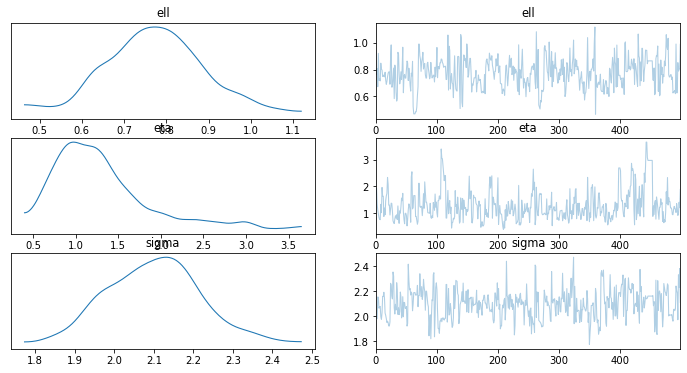

In [16]:
az.plot_trace(gp_trace, var_names=["ell", "eta", "sigma"]);

In [17]:
x_new = np.linspace(0, 20, 200)[:, None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


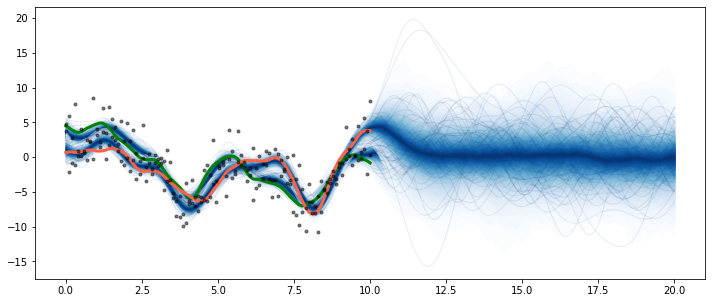

In [18]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
plot_gp_dist(ax, f_pred[:,200:], X_new[200:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)

# ax.plot(X_new[:200,0], f_pred[:,:200], '^k', ms=3, alpha=0.5, label="Data 1");
# ax.plot( X_new[200:,0], f_pred[:,200:], '^k', ms=3, alpha=0.5, label="Data 2");

ax.plot(x, f1, "green", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");

### Using LatentKron

In [19]:
from pymc.math import kronecker
import aesara.tensor as at

In [20]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), initval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    
    B = at.dot(W, W.T) + at.diag(kappa)
    
    cov_func = lambda x: kronecker(B, cov(x))
    #coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    #cov_func = coreg * cov
    #cov_func2 = pm.gp.cov.Kron([B, cov])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
ERROR (aesara.graph.opt): Optimization failure due to: constant_folding
ERROR (aesara.graph.opt): node: Assert{msg=Could not broadcast dimensions}(TensorConstant{400}, TensorConstant{False})
ERROR (aesara.graph.opt): TRACEBACK:
ERROR (aesara.graph.opt): Traceback (most recent call last):
  File "/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/graph/opt.py", line 1861, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/graph/opt.py", line 1066, in transform
    return self.fn(fgraph, node)
  File "/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 2868, 

AssertionError: Could not broadcast dimensions

In [ ]:
type(cov_func)

In [ ]:
type(B)

In [ ]:
B.eval()

In [ ]:
X.shape, y.shape

In [ ]:
cov(X).eval().shape

In [ ]:
coreg(X).eval().shape

In [ ]:
cov_func(X).eval().shape

In [ ]:
x_new = np.linspace(0, 20, 200)[:, None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

In [ ]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    
    cov_func = pm.gp.cov.Kron([coreg, cov])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

In [ ]:
X.shape

In [ ]:
kappa.eval()

In [ ]:

with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    
    gp = pm.gp.MarginalKron(cov_funcs=[coreg, cov])
    
    Xs = [X, W.eval()]
   
    sigma = pm.HalfNormal("sigma", sigma=3)
    y_ = gp.marginal_likelihood("y", Xs=Xs, y=y, sigma=sigma)

In [ ]:
coreg(X).eval().shape, cov(X).eval().shape

In [ ]:
f.eval().shape

In [ ]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)